In [23]:
import os
import re
import scipy.io
import pandas as pd
from scipy import ndimage
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from shutil import move, copy
import scipy.io as sio


In [ ]:
# беру папку с картинками 
# формирую словарь индексов на вход индекс 
# по индексу определяется разметка и выборка 
# внутри инициализация с путем к папке 

In [19]:
# src_dir = '/Volumes/Ginger/Datasets/ADE20K_2016_07_26/images/training/s/street/'
# src_dir = '/Volumes/Ginger/Datasets/ADE20K_2016_07_26/'
src_dir = './gt/frankfurt/' #ADE_train_00016858'

In [11]:
# палитра 

In [16]:
k_colors = np.array([[  0,   0,   0],
       [250, 205, 205], # cap
       [ 5,  91,  44],  # Helmet
       [254, 236, 212], # Face
       [142,  67,   12], # Hair
       [222,  168, 142], # Left-arm
       [254,  235,   167], # Right-arm
       [255, 204,   121], # Left-hand
       [218, 138,   105], # Right-hand
       [165, 93,   252], # Protector
       [232, 199,   255], # Bikini/bra
       [248, 215,   108], # Jacket/windbreaker/hoodie 
       [212, 232,   247], # Tee-shirt
       [84, 134,   187], # Polo-shirt
       [8, 84,   199], # Sweater
       [48, 96,   144], # Singlet
       [252, 226,   177], # Torso-skin
       [164, 103,   46], # Pants
       [252, 197,   227], # Shorts/swim-shorts
       [ 146, 125,   223], # Skirt
       [ 230, 250,   177], # Stockings
       [ 238, 242,   246], # Socks
       [ 181, 110,   60], # Left-boot
       [ 107, 52,  7], # Right-boot
       [ 110, 47,  2], # Left-shoe
       [ 184, 95,  31], # Right-shoe 
       [ 131, 204, 188], # Left-highheel
       [ 71, 179, 159], # Right-highheel
       [ 171, 125, 51], # Left-sandal
       [ 252, 226, 164], # Right-sandal
       [ 222, 208, 190], # Left-leg
       [ 234, 204, 152], # Right-leg
       [ 225, 193, 178], # Left-foot
       [ 220, 143, 60], # Right-foot
       [ 105, 211, 212], # Coat
       [ 255, 133, 192], # Dress
       [ 240, 61, 201], # Robe
       [ 153,  49, 111], # Jumpsuit
       [ 170,  95, 140], # Other-full-body-clothes
       [ 255,  216, 88], # Headwear
       [ 17,   187, 255], # Backpack
       [ 255,   226, 211], # Ball
       [ 255,   167, 122], # Bats
       [ 116,   76, 65], # Belt
       [161,   198, 255], # Bottle
       [219,   190, 114], # Carrybag
       [124,   62, 85], # Cases
       [169,   211, 212], # Sunglasses
       [176,   248, 255], # Eyewear
       [118,   104, 172], # Glove
       [247,   221, 222], # Scarf
       [203,   178, 244], # Umbrella
       [89,   48, 0], # Wallet/purse
       [144,   191, 73], # Watch
       [207,   255, 241], # Wristband
       [102,   179, 255], # Tie
       [180,   214,  180], # Other-accessary
       [39,   255,  242], # Other-upper-body-clothes
       [227,   159,  177]], dtype='uint8') # Other-lower-body-clothes

In [17]:
# показали подгруженное изобржение
# сформированли маску
# отобрали пиксель?
# сгруппировали пады

In [20]:
def show_image(img, dpi=72):
    plt.figure(dpi=dpi)
    plt.imshow(img)
    plt.show()
    
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def pad_rgb(img, pad, mode='reflect'):
    single_chan = False
    if len(img.shape) == 2:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
        single_chan = True
    
    n_chan = img.shape[2]
    new_chans = []
    for j in range(n_chan):
        if mode == 'reflect':
            chan = np.pad(img[:, :, j], pad, mode=mode)
        else:
            chan = np.pad(img[:, :, j], pad, mode=mode, constant_values=(0,))
        new_chans.append(chan)
    
    if not single_chan:
        new_img = np.dstack(new_chans)
    else:
        new_img = new_chans[0]
    
    return new_img


def pad_square_rgb(img, mode='reflect', dict_mode=False):
    rows = img.shape[0]
    cols = img.shape[1]
    pad_left = 0
    pad_top = 0

    if rows == cols:
        if dict_mode:
            return {'img': img, 'pad_left': 0, 'pad_top': 0}
        else:
            return img
    elif rows > cols:
        d = rows - cols
        pad_cols = d // 2
        if d % 2 == 0:
            pad = ((0, 0), (pad_cols, pad_cols))
        else:
            pad = ((0, 0), (pad_cols, pad_cols + 1))
        pad_left = pad_cols
        pad_top = 0
    elif cols > rows:
        d = cols - rows
        pad_rows = d // 2
        if d % 2 == 0:
            pad = ((pad_rows, pad_rows), (0, 0))
        else:
            pad = ((pad_rows, pad_rows + 1), (0, 0))
        pad_left = 0
        pad_top = pad_rows
    img = pad_rgb(img, pad, mode)
    if dict_mode:
        return {'img': img, 'pad_left': pad_left, 'pad_top': pad_top}
    else:
        return img

In [23]:
# cовмещаются пути к директории и к палитре, загружается в палитру внутри 

In [24]:
# colors = scipy.io.loadmat(os.path.join(src_dir, 'color150.mat'))
# colors = scipy.io.loadmat(src_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/gt/frankfurt/.mat'

In [3]:
colors['colors']

In [ ]:
#  основное тело 
'!'
'   Иинициализация     '
'   Получение имени файла     '
'   Получение списка имен     '
'   Получение цветовой гаммы    '
'!'

In [18]:
class ADE20kDataset:
    def __init__(self, path, split):
        self.path = path
        self.colors = scipy.io.loadmat(os.path.join(self.path, 'color150.mat'))['colors']
        # self.int_colors = (self.colors * 255).astype('uint8')
        self.int_colors = k_colors
        
        map_path = os.path.join(self.path, 'mapFromADE.csv')
        with open(map_path) as f:
            lines = f.readlines()

        self.ADE20k_dict = {}

        for l in lines:
            pattern = '\d+'
            vals =  re.findall(pattern, l)
            self.ADE20k_dict[int(vals[1])] = int(vals[0])
        
        self.color_path = os.path.join(self.path, 'images',  split, 's', 'street')
        self.label_path = os.path.join(self.path, 'images',  split, 's', 'street')
        
        self.image_names = self.get_image_names(self.color_path)
        self.label_names = self.get_label_names(self.label_path)
        
        # self.circle = create_circular_mask(7, 7)
        
    def get_image_names(self, path):
        result = os.listdir(path)
        # result = sorted(, key=lambda x: int(x.split('.')[0][10:19]))
        result = list(filter(lambda x: '.jpg' in x, result))
        
        return result
    
    def get_label_names(self, path):
        result = [x.split('.')[0] + '_seg.png' for x in self.image_names]
        
        return result
            
    def label2color(self, img):
        result = np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
        
        for c_id in range(self.colors.shape[0]):
            mask = img == c_id
            #mask = ndimage.binary_closing(mask, structure=self.circle, iterations=2).astype(bool)
            result[mask] = self.int_colors[c_id]
        
        return result
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        try:
            img = Image.open(os.path.join(self.color_path, self.image_names[idx])).convert('RGB')
        except OSError:
            return {'color':None}
        
        label_name = self.label_names[idx]
        label_name_1 = label_name.replace('_seg', '_parts_1')
        label_name_2 = label_name.replace('_seg', '_parts_2')
        label = Image.open(os.path.join(self.color_path, label_name)).convert('RGB')
        class_arr = np.array(label)
        l_path_1 = os.path.join(self.color_path, label_name_1)
        l_path_2 = os.path.join(self.color_path, label_name_2)
        if os.path.exists(l_path_1):
            label_1 = Image.open(l_path_1).convert('RGB')
            class_arr_1 = np.array(label_1)
        else:
            class_arr_1 = np.zeros_like(class_arr)
        if os.path.exists(l_path_2):
            label_2 = Image.open(l_path_2).convert('RGB')
            class_arr_2 = np.array(label_2)
        else:
            class_arr_2 = np.zeros_like(class_arr)
        
        fn, ext = os.path.splitext(self.image_names[idx])
        
        labels = []
        
        img_arr = np.array(img)

        
        
        if len(img_arr.shape) < 2:
            return {'color':None}
        
        if min(img_arr.shape[0], img_arr.shape[1]) == 0:
            return {'color':None}
        
        instance = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype='uint8')
        class_img = np.zeros((img_arr.shape[0], img_arr.shape[1], 3), dtype='uint8')
        class_id_img = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype='uint16')
        
        class_arr_orig = class_arr.copy()
        
        parts = [class_arr_1, class_arr_2]
        for p in parts:
            mask = np.all(p[:,:,0:2] > 0, axis=-1)
            class_arr[mask,0:2] = p[mask,0:2]
        
        class_arr_16 = class_arr.astype('uint16')
        class_arr_16 = (class_arr_16[:,:,0]/10 * 256 + class_arr_16[:,:,1]).astype('uint16')
        
        
        ids = np.unique(class_arr_16)
        for c_id in ids:
            if c_id == 0:
                continue
            
            mask = class_arr_16 == c_id
            #c_id_150 = self.ADE20k_dict[c_id]
            class_id_img[mask] = c_id
            
            class_img[mask] = all_colors[c_id]#self.colors[c_id_150-1]
        
        instance_dict = {}
        
        class_arr_16_orig = class_arr_orig.astype('uint16')
        class_arr_16_orig = (class_arr_16_orig[:,:,0]/10 * 256 + class_arr_16_orig[:,:,1]).astype('uint16')
        mask = class_arr_16_orig == 401
        mask = mask.astype('bool')
        instance = class_arr_orig[:,:,2]
        instance = instance * mask
        
        instance_dict[1] = instance
        
        '''
        for i, l in enumerate(label_names):
            label = Image.open(os.path.join(self.label_path, l))
            img = np.array(label)
            if len(img.shape) < 3:
                continue
            img = img[:,:,0]
            label_img = self.label2color(img)
            label_img = Image.fromarray(label_img)
            
            class_img += label_img
            class_id_img += img
            
            mask = img > 0
            mask = ndimage.binary_closing(mask, structure=self.circle, iterations=2).astype(bool)
            instance[mask] = i+1
            
            labels.append(label_img)
        
        instance_dict[1] = instance'''
            
        
        return {'color':img_arr, 'class':class_img, 'class_id':class_id_img, 'instance':instance_dict, 'name':fn}

In [14]:
ds = ADE20kDataset(src_dir, 'validation')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Ginger/Datasets/ADE20K_2016_07_26/color150.mat'

In [15]:
colors_path = os.path.join(src_dir, 'colornames.csv')

all_colors = np.zeros((3148, 3), dtype='uint8')

with open(colors_path) as f:
    lines = f.readlines()

for i, l in enumerate(lines[1:]):
    if i >= all_colors.shape[0]:
        break
    vals =  l.split(',')
    h = vals[1].lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    all_colors[i,:] = rgb
    #print(vals)

all_colors[0] = [0, 0 ,0]

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Ginger/Datasets/ADE20K_2016_07_26/colornames.csv'

In [16]:
for key, val in ds.ADE20k_dict.items():
    all_colors[key] = ds.colors[val-1]

NameError: name 'ds' is not defined

In [17]:
len(ds)

NameError: name 'ds' is not defined

In [19]:
img = ds[0]['instance'][1]

In [ ]:
# отрисовка машинки

In [20]:
img.shape

(1200, 1600)

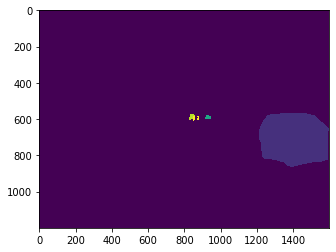

In [21]:
show_image(img)

In [22]:
class IQDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        if item['color'] is None:
            return {'actors':None}
        
        color = item['color']
        label = item['class']
        instance = item['instance'][1]
        # num = int(item['name'])
        
        inst_ids = np.unique(instance)
        # print(inst_ids)
        
        actors = {1:[]}
        
        for inst_id_idx in range(1, inst_ids.shape[0]):
            inst_id = inst_ids[inst_id_idx]
            actor = {}

            mask = instance == inst_id
            
            if mask.sum() == 0:
                continue
            rmin, rmax, cmin, cmax = bbox2(mask)
            
            crop_color = (color * mask[:,:,None])[rmin:rmax, cmin:cmax]
            crop_label = (label * mask[:,:,None])[rmin:rmax, cmin:cmax]
            crop_mask = mask[rmin:rmax, cmin:cmax]
            
            crop_color = pad_square_rgb(crop_color, mode='constant')
            crop_label = pad_square_rgb(crop_label, mode='constant')
            crop_mask = pad_square_rgb(crop_mask, mode='constant')
            
            actor['color'] = crop_color
            actor['class'] = crop_label
            actor['mask'] = crop_mask.astype('uint8') * 255
            actor['name'] = f'{item["name"]}_{inst_id:03d}'
            
            actors[1].append(actor)
        
        return {'actors':actors}

In [23]:
iqds = IQDataset(ds)

In [24]:
len(ds)

203

In [25]:
sample = iqds[0]

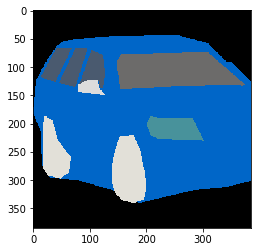

In [26]:
c_img = sample['actors'][1][0]['class']
show_image(c_img)

In [27]:
dst_dir = '../datasets/ADE20k_actors_val/'

In [28]:
iqds[0]['actors'][1][0]['name']

'ADE_val_00000777_030'

In [30]:
start = 0
pbar = tqdm(total=len(iqds), initial=start)

for kk in range(start, len(iqds)):
    sample = iqds[kk]
    actors = sample['actors']
    if actors is None:
        pbar.update(1)
        continue
    for i, a in enumerate(actors[1]):
        color = a['color']
        mask = a['mask']
        label = a['class']
        name = a['name']
        
        dst_color_path = os.path.join(dst_dir, 'ColorImages', f'{name}.png')
        dst_label_path = os.path.join(dst_dir, 'Edges', f'{name}.png')
        
        if os.path.exists(dst_color_path):
            continue
        
        if max(color.shape[0], color.shape[1]) < 410:
            pass
            # continue
            
        color = np.dstack((color, mask))
        
        color = Image.fromarray(color)
        label = Image.fromarray(label)
        
        color = color.resize((512, 512), resample=Image.LANCZOS)
        label = label.resize((512, 512), resample=Image.NEAREST)
        
        color.save(dst_color_path)
        label.save(dst_label_path)
        
    pbar.update(1)

A Jupyter Widget

In [32]:
dst_color_dir = os.path.join(dst_dir, 'ColorImages')
dst_label_dir = os.path.join(dst_dir, 'Semantic')
dst_noise_dir = os.path.join(dst_dir, 'ColorNoise')

In [209]:
for f in sorted(os.listdir(dst_label_dir)):
    c_fp = os.path.join(dst_color_dir, f)
    l_fp = os.path.join(dst_label_dir, f)
    
    tmp_fp = l_fp + 'BAD'
    
    if not os.path.exists(c_fp):
        #move(l_fp, tmp_fp)
        print(c_fp)

### Bake color noise

In [34]:
files = os.listdir(dst_color_dir)
pbar = tqdm(total=len(files))

for f in sorted(files):
    c_fp = os.path.join(dst_color_dir, f)
    l_fp = os.path.join(dst_label_dir, f)
    
    dst_fp = os.path.join(dst_noise_dir, f)
    
    if not '.png' in c_fp:
        pbar.update(1)
        continue
        
    c_img = Image.open(c_fp)
    l_img = Image.open(l_fp)
    
    c_img = np.array(c_img)
    l_img = np.array(l_img)
    
    n_img = np.zeros((c_img.shape[0], c_img.shape[1], 3), dtype='uint8')
    
    colors = np.unique(l_img.reshape(-1, l_img.shape[2]), axis=0)
    
    for k in range(1, colors.shape[0]):
        mask = np.all(l_img == colors[k], axis=-1)
        vals = c_img[mask,0:3]
        np.random.shuffle(vals)
        n_img[mask] = vals
    
    n_img = Image.fromarray(n_img)
    n_img.save(dst_fp)
    
    # print(c_fp)
    # break
    pbar.update(1)


A Jupyter Widget

### Bake BG

In [35]:
dst_bg_color_dir = '../datasets/ADE20k_bg_val/ColorImages/'
dst_bg_label_dir = '../datasets/ADE20k_bg_val/Edges/'
dst_bg_insts_dir = '../datasets/ADE20k_bg_val/Instance/'

In [36]:
def ratio_resize(shape, min_target_dim):
    new_shape = (0, 0)
    # portrait
    if shape[0] >= shape[1]:
        new_shape = (round(shape[0]/shape[1]*min_target_dim), min_target_dim)
    else:
        new_shape = (min_target_dim, round(shape[1]/shape[0]*min_target_dim))
    
    return new_shape

In [38]:
start = 0
pbar = tqdm(total=len(ds), initial=start)

for kk in range(start, len(ds)):
    sample = ds[kk]
    if sample['color'] is None:
        pbar.update(1)
        continue
    
    inst_img = sample['instance'][1]
    if inst_img.sum() == 0:
        pbar.update(1)
        continue
    
    name = sample['name']
    fn, ext = os.path.splitext(name)
    padded_name = name # f'{int(name):06d}'
    '''if not padded_name in good_names:
        pbar.update(1)
        continue'''
        
    # show_image(ds[kk]['color'])
    
    # Color
    col_img = sample['color']
    shape = col_img.shape[0:2]
    col_img = Image.fromarray(col_img)
    
    new_shape = ratio_resize(shape, 512)
    
    col_img = col_img.resize((new_shape[1], new_shape[0]), resample=Image.LANCZOS)
    
    dst_color_name = os.path.join(dst_bg_color_dir, padded_name+'.png')
    
    col_img.save(dst_color_name)
    
    # label
    lab_img = sample['class']
    inst_img = sample['instance'][1]
    mask = (inst_img > 0).astype('bool')
    
    lab_img = Image.fromarray(lab_img)
    lab_img = lab_img.resize((new_shape[1], new_shape[0]), resample=Image.NEAREST)
    dst_lab_name = os.path.join(dst_bg_label_dir, padded_name+'.png')
    
    lab_img.save(dst_lab_name)
    
    dst_inst_name = os.path.join(dst_bg_insts_dir, padded_name+'.png')
    inst_img = Image.fromarray(inst_img)
    inst_img = inst_img.resize((new_shape[1], new_shape[0]), resample=Image.NEAREST)
    inst_img.save(dst_inst_name)
    
    pbar.update(1)

A Jupyter Widget

### Make good files

In [20]:
dst_good_dir = '/Volumes/Ginger/Datasets/LV-MHP-v2/train/images_good'
dst_good_dir_png = '/Volumes/Ginger/Datasets/LV-MHP-v2/train/images_good_png'
src_good_dir = '/Volumes/Ginger/Datasets/LV-MHP-v2/val/images'

In [19]:
pbar = tqdm(total=len(good_names))

for n in good_names:
    name = os.path.join(src_good_dir, str(int(n))+'.jpg')
    if os.path.exists(name):
        dst_name = os.path.join(dst_good_dir, n+'.jpg')
        copy(name, dst_name)
        
    pbar.update(1)

A Jupyter Widget

In [22]:
pbar = tqdm(total=len(good_names))

for n in good_names:
    src_name = os.path.join(dst_good_dir, n+'.jpg')
    dst_name = os.path.join(dst_good_dir_png, n+'.png')
    
    img = Image.open(src_name)
    img.save(dst_name)
    pbar.update(1)

A Jupyter Widget

/Users/vladimirknyaz/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


### Bake color noise

In [17]:
dst_color_dir = '../datasets/ADE20k_bg_val/ColorImages/'
dst_label_dir = '../datasets/ADE20k_bg_val/Edges/'
dst_noise_dir = '../datasets/ADE20k_bg_val/ColorNoise/'

In [45]:
files = os.listdir(dst_color_dir)
pbar = tqdm(total=len(files))

for f in sorted(files):
    c_fp = os.path.join(dst_color_dir, f)
    l_fp = os.path.join(dst_label_dir, f)
    
    dst_fp = os.path.join(dst_noise_dir, f)
    
    if not '.png' in c_fp:
        pbar.update(1)
        continue
        
    c_img = Image.open(c_fp)
    l_img = Image.open(l_fp)
    
    c_img = np.array(c_img)
    l_img = np.array(l_img)
    
    break

A Jupyter Widget

In [55]:
np.unique(l_img.reshape(-1, l_img.shape[2]), axis=0)

array([[  0,   0,   0],
       [ 39, 255, 242],
       [ 71, 179, 159],
       [ 80,  50,  50],
       [120, 120, 120],
       [131, 204, 188],
       [142,  67,  12],
       [144, 191,  73],
       [150,   5,  61],
       [180, 214, 180],
       [218, 138, 105],
       [220, 143,  60],
       [221,  45,  78],
       [222, 168, 142],
       [222, 208, 190],
       [225, 193, 178],
       [230, 250, 177],
       [234, 204, 152],
       [252, 197, 227],
       [252, 226, 177],
       [254,  10, 128],
       [254, 235, 167],
       [254, 236, 212],
       [255,   8,  41],
       [255, 133, 192],
       [255, 204, 121]], dtype=uint8)

In [18]:
files = os.listdir(dst_color_dir)
pbar = tqdm(total=len(files))

for f in sorted(files):
    c_fp = os.path.join(dst_color_dir, f)
    l_fp = os.path.join(dst_label_dir, f)
    
    dst_fp = os.path.join(dst_noise_dir, f)
    
    if not '.png' in c_fp:
        pbar.update(1)
        continue
        
    c_img = Image.open(c_fp)
    l_img = Image.open(l_fp)
    
    c_img = np.array(c_img)
    l_img = np.array(l_img)
    
    n_img = np.zeros((c_img.shape[0], c_img.shape[1], 3), dtype='uint8')
    
    colors = np.unique(l_img.reshape(-1, l_img.shape[2]), axis=0)
    
    for k in range(1, colors.shape[0]):
        mask = np.all(l_img == colors[k], axis=-1)
        vals = c_img[mask,0:3]
        np.random.shuffle(vals)
        n_img[mask] = vals
    
    n_img = Image.fromarray(n_img)
    n_img.save(dst_fp)
    
    # print(c_fp)
    # break
    pbar.update(1)

A Jupyter Widget

In [94]:
mask.shape

(640, 1024)

In [25]:
len(good_names)

12111

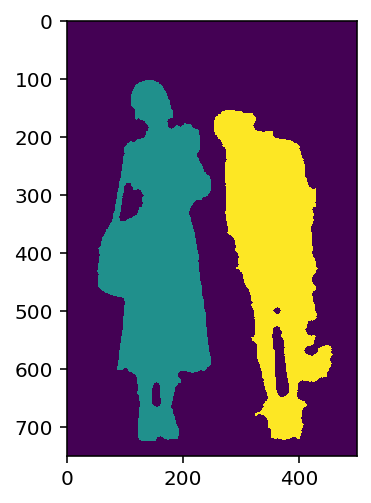

In [10]:
show_image(img, dpi=144)

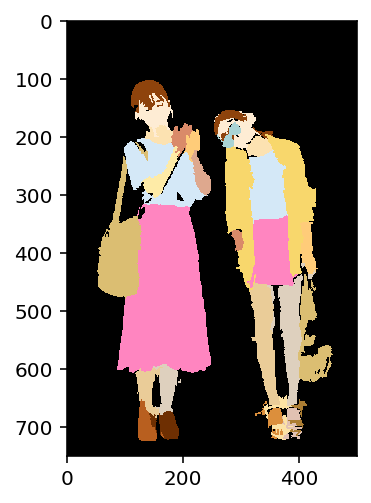

In [488]:
show_image(ds[-1]['class'], dpi=144)

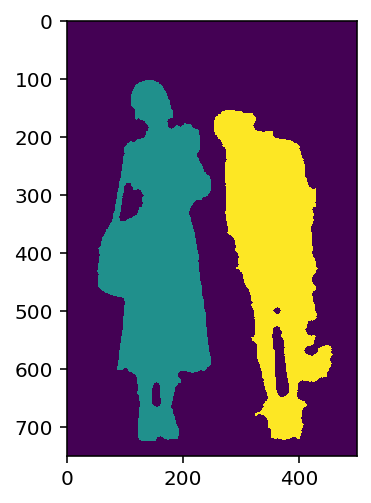

In [483]:
show_image(ds[-1]['instance'][1], dpi=144)

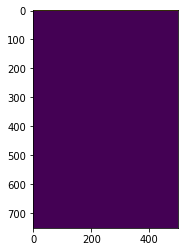

In [440]:
plt.figure()
plt.imshow(ds[-1]['instance'][1])
plt.show()